# ⚽ Football Shot Analysis & Expected Goals Modeling

Exploratory analysis of shot geometry, player roles, and contextual factors underlying Expected Goals (xG) estimation.


In [5]:

# ===============================
# Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    roc_curve,
    auc as sklearn_auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from matplotlib.patches import Rectangle
from tabulate import tabulate
# ===============================
# Project modules
# ===============================
from preprocessing import (
    load_data,
    add_outcome,
    convert_bool_columns,
    add_distance_and_angle,
    add_body_part_dummies,
    remove_penalties,
    add_categorical_dummies,
    add_macro_play_pattern,
    add_macro_position,
    add_macro_position_dummies,
    add_opening_angle,
    select_shots_on_target
)

from eda import (
    penalty_summary,
    dummy_correlation,
    plot_outcome_distribution,
    plot_correlation_heatmap,
    plot_boxplots,
    compute_vif,
    plot_shot_distance_distribution,
    plot_shot_angle_distribution,
    plot_goal_prob_by_angle,
    plot_goal_prob_by_distance,
    mean_shot_angle_by_role,
    mean_shot_distance_by_role,
    assign_shot_zones,
    plot_shot_zones_field,
    plot_goal_heatmaps_by_shot_zone,
    plot_xg_vs_distance,
    goal_prob_by_role,
    plot_distance_vs_opening_angle,
    goal_prob_by_distance_pressure,
    goal_prob_by_binary_vars,
    plot_goal_prob_binary_vars,
    plot_adaptive_goal_grid,
    top_zones_table
)

from model import (
    calibration_table,
    plot_calibration,
    correlation_with_statsbomb,
    plot_roc_curve,
    compute_log_loss,
    real_vs_expected_goals,
    train_rf_model,
    rf_predictions,
    mean_xg_by_outcome,
    train_xgb_model,
    xgb_predictions
)


In [6]:

# ============================================================
# Load dataset
# ============================================================

df = load_data("data/xg_dataset.xlsx")

# Binary outcome: Goal vs No Goal
df = add_outcome(df)

In [7]:

# ============================================================
# Penalty summary
# ============================================================
pen_summary = penalty_summary(df)
print("Penalty summary:")
print(pen_summary)

# ============================================================
# Remove penalties
# ============================================================
df = remove_penalties(df)

Penalty summary:
{'total_penalties': 1026, 'penalties_scored': 766, 'empirical_xg': 0.746588693957115}


In [8]:

# ============================================================
# Convert boolean columns
# ============================================================
bool_cols = [
    "shot_aerial_won", "shot_first_time", "shot_one_on_one",
    "under_pressure", "shot_deflected", "shot_open_goal",
    "shot_redirect", "shot_saved_off_target", "shot_saved_to_post",
    "shot_follows_dribble"
]
df = convert_bool_columns(df, bool_cols)

# ============================================================
# Distance and angle computation
# ============================================================
df = add_distance_and_angle(df)
df = add_opening_angle(df)

# ============================================================
# Body part dummies
# ============================================================
df, body_part_cols = add_body_part_dummies(df)
print("Body part dummy columns:", body_part_cols)


# ============================================================
# Categorical dummies (shot type & technique)
# ============================================================
cat_cols = ["shot_type", "shot_technique"]
df = add_categorical_dummies(df, cat_cols, drop_first=False)

# Check
for col in cat_cols:
    print(f"\nDummies created for {col}:")
    print([c for c in df.columns if c.startswith(col + "_")])



Body part dummy columns: ['shot_body_part_Left Foot', 'shot_body_part_Other', 'shot_body_part_Right Foot']

Dummies created for shot_type:
['shot_type_Corner', 'shot_type_Free Kick', 'shot_type_Open Play']

Dummies created for shot_technique:
['shot_technique_Backheel', 'shot_technique_Diving Header', 'shot_technique_Half Volley', 'shot_technique_Lob', 'shot_technique_Normal', 'shot_technique_Overhead Kick', 'shot_technique_Volley']


In [9]:

# ============================================================
# Correlation: shot technique dummies vs Outcome
# ============================================================
dummy_cols = [col for col in df.columns if col.startswith("shot_technique_")]
corr_cols = dummy_cols + ["Outcome"]

corr_outcome_dummy = (
    df[corr_cols]
    .corr(numeric_only=True)["Outcome"]
    .sort_values(ascending=False)
)

print("\nCorrelation of dummy variables with Outcome:")
print(corr_outcome_dummy)


Correlation of dummy variables with Outcome:
Outcome                         1.000000
shot_technique_Lob              0.050340
shot_technique_Diving Header    0.024445
shot_technique_Volley           0.020583
shot_technique_Backheel         0.002359
shot_technique_Half Volley     -0.002253
shot_technique_Overhead Kick   -0.004327
shot_technique_Normal          -0.025904
Name: Outcome, dtype: float64


In [10]:

# ============================================================
# Shot type distribution
# ============================================================
shot_type_dummies = [col for col in df.columns if col.startswith("shot_type_")]

print("\n=== Shot Type ===")
for col in shot_type_dummies:
    count = df[col].sum()
    perc = count / len(df) * 100
    print(f"{col}: {count} shots ({perc:.2f}%)")

print("Decision: drop 'shot_type' because 'Open Play' dominates (~94.78%)")



=== Shot Type ===
shot_type_Corner: 20 shots (0.03%)
shot_type_Free Kick: 3517 shots (5.19%)
shot_type_Open Play: 64240 shots (94.78%)
Decision: drop 'shot_type' because 'Open Play' dominates (~94.78%)


In [11]:

# ============================================================
# Macro Play Pattern
# ============================================================
df, macro_cols = add_macro_play_pattern(df)
print("Macro play pattern dummy columns:", macro_cols)

corr_macro_outcome = dummy_correlation(
    df,
    dummy_prefixes=["macro_play_pattern_"],
    target="Outcome"
)

print("\nCorrelation of macro play patterns with Outcome:")
print(corr_macro_outcome)


Macro play pattern dummy columns: ['macro_play_pattern_Open Play', 'macro_play_pattern_Other', 'macro_play_pattern_Set Piece', 'macro_play_pattern_Throw In']

Correlation of macro play patterns with Outcome:
Outcome                         1.000000
macro_play_pattern_Open Play    0.016303
macro_play_pattern_Other        0.000427
macro_play_pattern_Throw In    -0.006896
macro_play_pattern_Set Piece   -0.029816
Name: Outcome, dtype: float64


In [12]:

# ============================================================
# Shot Technique summary
# ============================================================
shot_technique_dummies = [
    col for col in df.columns if col.startswith("shot_technique_")
]

print("=== Shot Technique ===")
for col in shot_technique_dummies:
    count = df[col].sum()
    perc = count / len(df) * 100
    print(f"{col}: {count} shots ({perc:.2f}%)")

print("Decision: drop shot_technique because ~77% are Normal shots")


=== Shot Technique ===
shot_technique_Backheel: 257 shots (0.38%)
shot_technique_Diving Header: 271 shots (0.40%)
shot_technique_Half Volley: 9357 shots (13.81%)
shot_technique_Lob: 723 shots (1.07%)
shot_technique_Normal: 52274 shots (77.13%)
shot_technique_Overhead Kick: 392 shots (0.58%)
shot_technique_Volley: 4503 shots (6.64%)
Decision: drop shot_technique because ~77% are Normal shots


In [13]:

# ============================================================
# Macro Position grouping
# ============================================================
df = add_macro_position(df)
df, macro_cols = add_macro_position_dummies(df)

corr_macro_outcome = dummy_correlation(
    df,
    dummy_prefixes=["macro_position_"],
    target="Outcome"
)

print("\nCorrelation of macro positions with Outcome:")
print(corr_macro_outcome)



Correlation of macro positions with Outcome:
Outcome                           1.000000
macro_position_Central Forward    0.075886
macro_position_Winger             0.018410
macro_position_Fullback          -0.038501
macro_position_Midfielder        -0.064912
Name: Outcome, dtype: float64


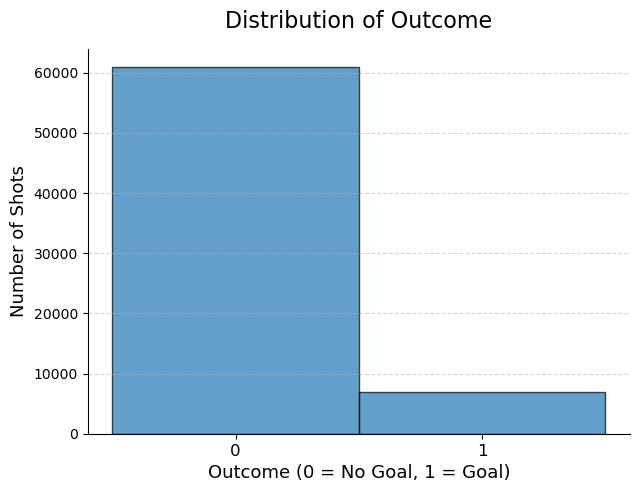

In [14]:

# ============================================================
# Outcome distribution
# ============================================================
plot_outcome_distribution(df, target="Outcome")


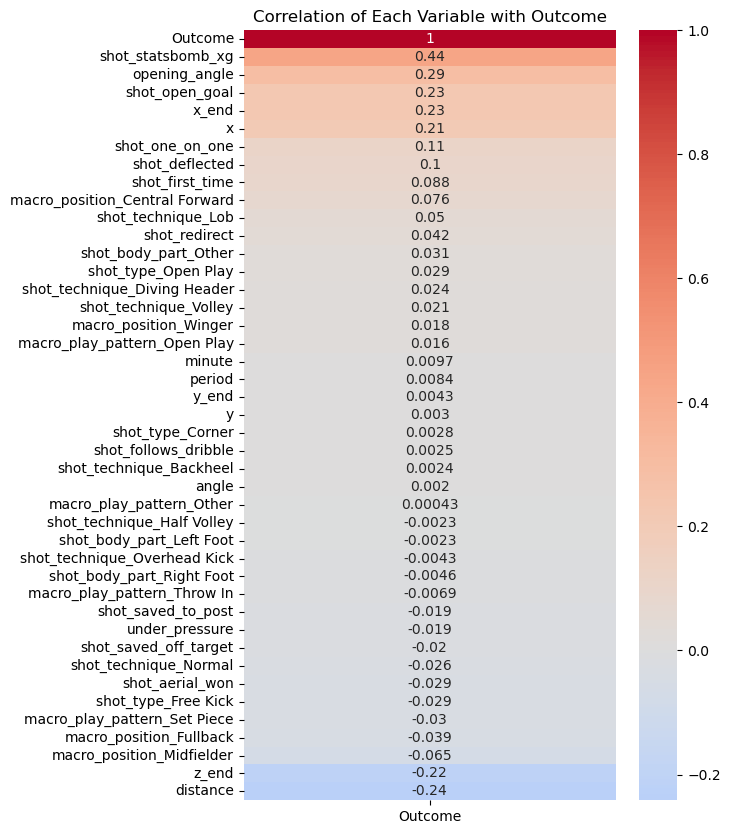

Outcome                           1.000000
shot_statsbomb_xg                 0.438541
opening_angle                     0.293627
shot_open_goal                    0.227095
x_end                             0.225412
x                                 0.207691
shot_one_on_one                   0.113362
shot_deflected                    0.100808
shot_first_time                   0.088412
macro_position_Central Forward    0.075886
shot_technique_Lob                0.050340
shot_redirect                     0.041911
shot_body_part_Other              0.031093
shot_type_Open Play               0.028651
shot_technique_Diving Header      0.024445
shot_technique_Volley             0.020583
macro_position_Winger             0.018410
macro_play_pattern_Open Play      0.016303
minute                            0.009664
period                            0.008387
y_end                             0.004335
y                                 0.003034
shot_type_Corner                  0.002773
shot_follow

In [15]:

# ============================================================
# Correlation analysis
# ============================================================
corr_outcome = (
    df.corr(numeric_only=True)["Outcome"]
    .sort_values(ascending=False)
)

plot_correlation_heatmap(df, target="Outcome")


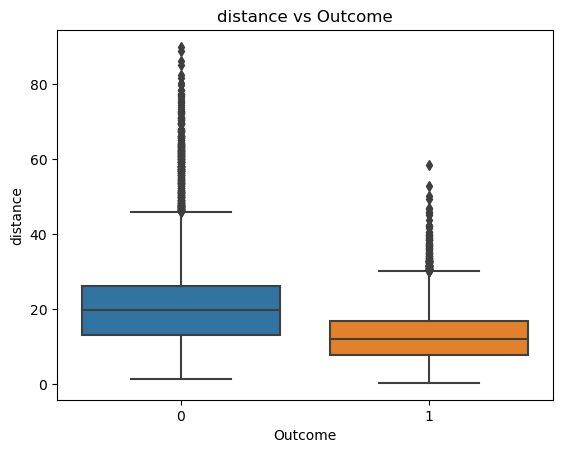

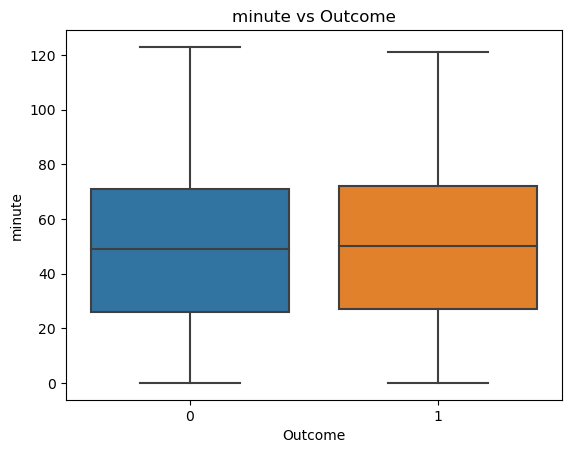

In [16]:

# ============================================================
# Feature selection based on correlation
# ============================================================
drop_cols = [
    "shot_body_part_Left Foot", "shot_body_part_Other", "shot_body_part_Right Foot",
    "shot_type_Free Kick", "shot_type_Corner", "shot_type_Open Play",
    "shot_technique_Lob", "shot_technique_Diving Header", "shot_technique_Volley",
    "shot_technique_Backheel", "shot_technique_Half Volley",
    "shot_technique_Overhead Kick", "shot_technique_Normal"
]

df1 = df.drop(columns=drop_cols)


# ============================================================
# Exploratory boxplots
# ============================================================
numeric_cols = ["distance", "minute"]
plot_boxplots(df, numeric_cols=numeric_cols, target="Outcome")


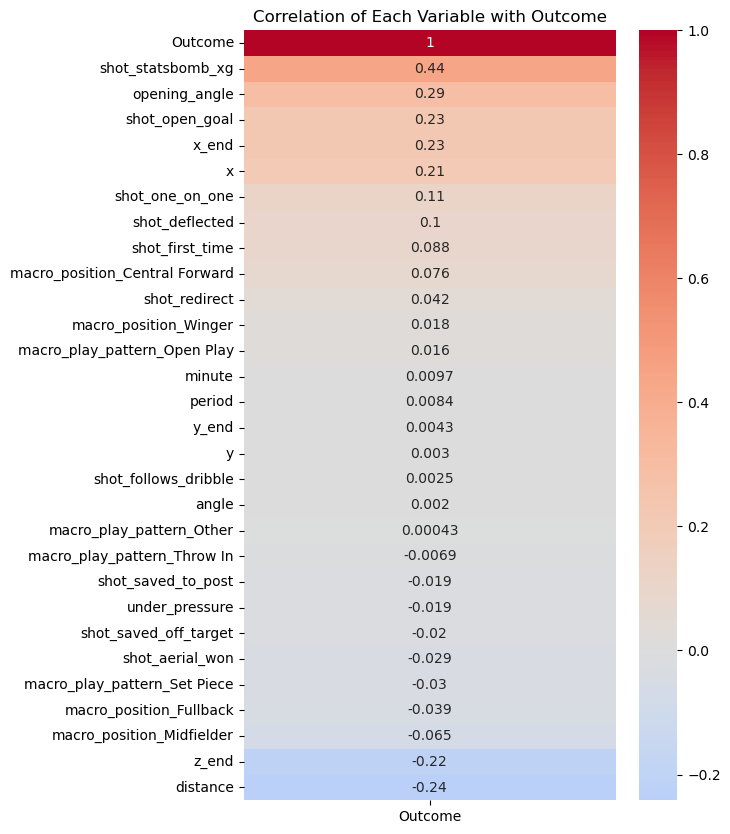

Outcome                           1.000000
shot_statsbomb_xg                 0.438541
opening_angle                     0.293627
shot_open_goal                    0.227095
x_end                             0.225412
x                                 0.207691
shot_one_on_one                   0.113362
shot_deflected                    0.100808
shot_first_time                   0.088412
macro_position_Central Forward    0.075886
shot_redirect                     0.041911
macro_position_Winger             0.018410
macro_play_pattern_Open Play      0.016303
minute                            0.009664
period                            0.008387
y_end                             0.004335
y                                 0.003034
shot_follows_dribble              0.002516
angle                             0.002003
macro_play_pattern_Other          0.000427
macro_play_pattern_Throw In      -0.006896
shot_saved_to_post               -0.018673
under_pressure                   -0.019238
shot_saved_

In [17]:

# ============================================================
# Correlation after feature reduction
# ============================================================
corr1 = df1.corr(numeric_only=True)
corr_outcome1 = corr1["Outcome"].sort_values(ascending=False)

plot_correlation_heatmap(df1, target="Outcome")


### Correlation with Goal Outcome

The correlation analysis highlights some intuitive and well-known patterns in shot quality.

Unsurprisingly, **StatsBomb xG** shows the strongest correlation with the goal outcome (ρ ≈ 0.44), confirming it as a strong baseline measure of shot quality.

Geometric features such as **opening angle**, **distance**, and shot location **x** are among the most correlated variables. In particular:
- Larger **opening angles** are associated with higher scoring probability.
- **Distance** from goal shows a negative correlation, as expected.
- Shots taken closer to the goal line (**higher x values**) tend to be more dangerous.

Binary contextual variables like **open goal**, **one-on-one situations**, and **first-time shots** also display positive correlations, although weaker in magnitude.

On the other hand, temporal variables (minute, period) and most categorical play-pattern indicators exhibit near-zero correlation, suggesting a limited marginal relationship with scoring probability.

Overall, these results are consistent with football domain knowledge and support the relevance of the selected features. However, since this is a univariate correlation analysis, interactions and non-linear effects are not captured and will be addressed in the modeling phase.


In [18]:

# ============================================================
# Final feature matrix and target 
# ============================================================
exclude_cols = [
    "Outcome", "shot_statsbomb_xg",
    "x_end", "y_end", "z_end",
    "shot_saved_off_target", "shot_saved_to_post",
    "shot_deflected", "period",
    "x", "y", "position", "play_pattern", "shot_outcome"
]

# Exclude post-shot information, outcome proxies and redundant raw coordinates
# to avoid data leakage and ensure causal xG estimation

X = df1.drop(columns=exclude_cols)
y = df1["Outcome"]



In [19]:

# Convert boolean features to numeric format for model compatibility
bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype(int)



In [20]:
# Stratified split to preserve goal / no-goal distribution
# across train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
 

# ============================================================
# Multicollinearity check (VIF)  
# ============================================================
vif_data = compute_vif(X_train)
print("\nVIF check:")
print(vif_data)


VIF check:
                           feature       VIF
0                           minute  4.142093
1                  shot_aerial_won  1.952286
2                  shot_first_time  1.683173
3                  shot_one_on_one  1.179786
4                   under_pressure  1.857855
5                   shot_open_goal  1.193142
6                    shot_redirect  1.021710
7             shot_follows_dribble  1.001395
8                         distance  9.847439
9                            angle  3.560534
10                   opening_angle  6.763048
11    macro_play_pattern_Open Play  7.081891
12        macro_play_pattern_Other  1.563618
13    macro_play_pattern_Set Piece  8.677397
14     macro_play_pattern_Throw In  4.193525
15  macro_position_Central Forward  4.535299
16         macro_position_Fullback  2.268573
17       macro_position_Midfielder  4.970407
18           macro_position_Winger  4.666759


In [21]:

# ============================================================
# Logistic Regression (Baseline xG Model)
# ============================================================

logit_model = sm.Logit(y_train, X_train).fit()
print(logit_model.summary())

# ============================================================
# Logistic Regression – Predictions (Train & Test)
# ============================================================

df1.loc[X_train.index, "xG_logit_train"] = logit_model.predict(X_train)
df1.loc[X_test.index, "xG_logit_test"] = logit_model.predict(X_test)


Optimization terminated successfully.
         Current function value: 0.275862
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                47443
Model:                          Logit   Df Residuals:                    47424
Method:                           MLE   Df Model:                           18
Date:                Thu, 05 Feb 2026   Pseudo R-squ.:                  0.1588
Time:                        12:03:17   Log-Likelihood:                -13088.
converged:                       True   LL-Null:                       -15558.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
minute                            -0.0001      0.001     -0.185     

### Logistic Regression Results

The logistic regression coefficients provide insights into how each feature affects the probability of scoring, conditional on the others.

Geometric variables play a central role. **Distance** from goal has a strong and highly significant negative effect, while **opening angle** is positively associated with scoring probability. Conversely, the basic **angle** variable shows a negative coefficient, suggesting that shots taken from wider positions reduce scoring chances when controlling for distance and opening angle.

Contextual shot characteristics are also highly informative. **Open goal** situations and **one-on-one shots** substantially increase the probability of scoring, while **aerial shots** exhibit a strong negative effect, indicating lower efficiency compared to shots taken on the ground. **First-time shots** are associated with a modest but significant positive effect.

The variable **under pressure** shows a small but statistically significant negative impact, consistent with the idea that defensive pressure reduces shot quality.

Regarding player positioning, shots taken by **wingers** and **central forwards** show the strongest positive associations with scoring probability, followed by midfielders and fullbacks, reflecting differences in typical shot selection and location across roles.

Finally, temporal effects such as the match **minute** are not statistically significant, suggesting no clear marginal effect of game time on scoring probability in this setting.


In [22]:

# ============================================================
# Logistic Regression – Mean xG by Outcome
# ============================================================

mean_goal_train, mean_nongoal_train = mean_xg_by_outcome(
    df1, X_train.index, "xG_logit_train"
)
mean_goal_test, mean_nongoal_test = mean_xg_by_outcome(
    df1, X_test.index, "xG_logit_test"
)

print("LOGIT TRAIN – Mean xG GOAL:", mean_goal_train)  
print("LOGIT TRAIN – Mean xG NO GOAL:", mean_nongoal_train) 
print("LOGIT TEST  – Mean xG GOAL:", mean_goal_test)
print("LOGIT TEST  – Mean xG NO GOAL:", mean_nongoal_test) 


LOGIT TRAIN – Mean xG GOAL: 0.22832773398298883
LOGIT TRAIN – Mean xG NO GOAL: 0.08769740477246339
LOGIT TEST  – Mean xG GOAL: 0.23135290930472424
LOGIT TEST  – Mean xG NO GOAL: 0.08774322362282434


BIN 0: mean xG=0.008, real goals=0.019, n_shots=2373
BIN 1: mean xG=0.015, real goals=0.020, n_shots=2373
BIN 2: mean xG=0.020, real goals=0.022, n_shots=2373
BIN 3: mean xG=0.025, real goals=0.028, n_shots=2372
BIN 4: mean xG=0.030, real goals=0.030, n_shots=2372
BIN 5: mean xG=0.035, real goals=0.028, n_shots=2372
BIN 6: mean xG=0.040, real goals=0.029, n_shots=2372
BIN 7: mean xG=0.047, real goals=0.042, n_shots=2372
BIN 8: mean xG=0.054, real goals=0.047, n_shots=2372
BIN 9: mean xG=0.061, real goals=0.054, n_shots=2372
BIN 10: mean xG=0.070, real goals=0.060, n_shots=2372
BIN 11: mean xG=0.080, real goals=0.087, n_shots=2372
BIN 12: mean xG=0.091, real goals=0.092, n_shots=2372
BIN 13: mean xG=0.104, real goals=0.103, n_shots=2372
BIN 14: mean xG=0.121, real goals=0.117, n_shots=2372
BIN 15: mean xG=0.141, real goals=0.152, n_shots=2372
BIN 16: mean xG=0.167, real goals=0.170, n_shots=2372
BIN 17: mean xG=0.203, real goals=0.203, n_shots=2372
BIN 18: mean xG=0.261, real goals=0.26

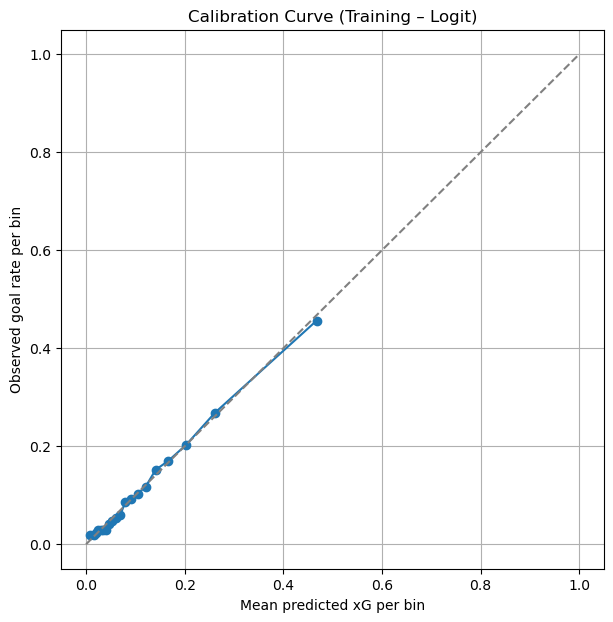

In [23]:

# ============================================================
# Logistic Regression – Calibration
# ============================================================

y_true_train = df1.loc[X_train.index, "Outcome"].values
y_pred_train = df1.loc[X_train.index, "xG_logit_train"].values

calibration_table(y_true_train, y_pred_train, n_bins=20)

plot_calibration(
    df1,
    X_train.index,
    "xG_logit_train",
    n_bins=20,
    title="Calibration Curve (Training – Logit)"
)


In [24]:

# ============================================================
# Logistic Regression – Comparison with StatsBomb xG
# ============================================================

print("\nStatsBomb xG summary:")
print(df1["shot_statsbomb_xg"].describe())

corr_train = correlation_with_statsbomb(df1, X_train.index, "xG_logit_train") 
corr_test = correlation_with_statsbomb(df1, X_test.index, "xG_logit_test") 

print("LOGIT vs StatsBomb (Train):", corr_train)
print("LOGIT vs StatsBomb (Test):", corr_test)



StatsBomb xG summary:
count    67777.000000
mean         0.095443
std          0.125041
min          0.000180
25%          0.027307
50%          0.052923
75%          0.104068
max          0.995122
Name: shot_statsbomb_xg, dtype: float64
LOGIT vs StatsBomb (Train): 0.8210505777940112
LOGIT vs StatsBomb (Test): 0.8160653665408322


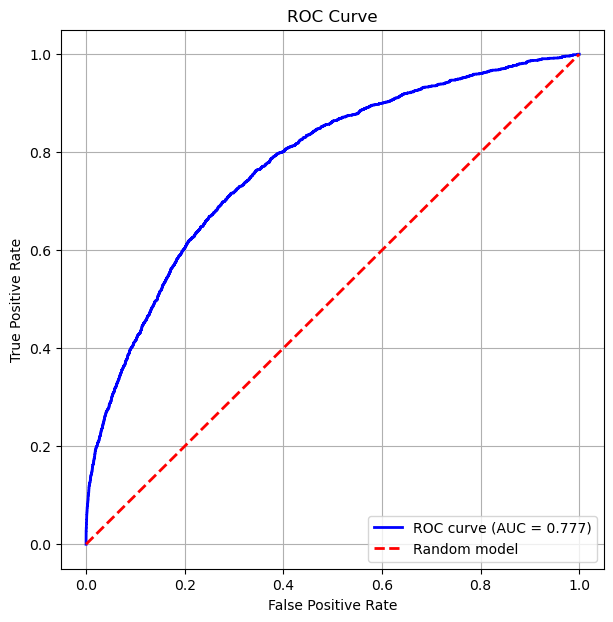

LOGIT Test AUC: 0.7768497818004465
LOGIT Test Log Loss: 0.2758317961394967
LOGIT TRAIN – Real: 4806 Expected: 4836.497336805767
LOGIT TEST  – Real: 2060 Expected: 2080.0066616512236


In [25]:

# ============================================================
# Logistic Regression – ROC & Log Loss (Test)
# ============================================================

y_score_test = df1.loc[X_test.index, "xG_logit_test"].values

roc_auc_logit = plot_roc_curve(y_test.values, y_score_test)   
logloss_logit = compute_log_loss(y_test.values, y_score_test) 

print("LOGIT Test AUC:", roc_auc_logit)
print("LOGIT Test Log Loss:", logloss_logit)

# ============================================================
# Logistic Regression – Real vs Expected Goals
# ============================================================

real_train, expected_train = real_vs_expected_goals(
    df1, X_train.index, "xG_logit_train"
)
real_test, expected_test = real_vs_expected_goals(
    df1, X_test.index, "xG_logit_test"
)

print("LOGIT TRAIN – Real:", real_train, "Expected:", expected_train) 
print("LOGIT TEST  – Real:", real_test, "Expected:", expected_test)


In [26]:

# ============================================================
# Random Forest xG Model
# ============================================================

rf_model = train_rf_model(
    X_train,
    y_train,
    n_estimators=500,
    max_depth=10,
    random_state=42
)

df1 = rf_predictions(
    df1,
    rf_model,
    X_train,
    X_test,
    col_train="xG_rf_train",
    col_test="xG_rf_test"
)

In [27]:

# ============================================================
# Random Forest – Mean xG by Outcome
# ============================================================

mean_goal_train, mean_nongoal_train = mean_xg_by_outcome(
    df1, X_train.index, "xG_rf_train"
)
mean_goal_test, mean_nongoal_test = mean_xg_by_outcome(
    df1, X_test.index, "xG_rf_test"
)

print("RF TRAIN – Mean xG GOAL:", mean_goal_train)  
print("RF TRAIN – Mean xG NO GOAL:", mean_nongoal_train) 
print("RF TEST  – Mean xG GOAL:", mean_goal_test) 
print("RF TEST  – Mean xG NO GOAL:", mean_nongoal_test) 


RF TRAIN – Mean xG GOAL: 0.2584953749046375
RF TRAIN – Mean xG NO GOAL: 0.08321142630998328
RF TEST  – Mean xG GOAL: 0.22447129916908495
RF TEST  – Mean xG NO GOAL: 0.08761155147892016


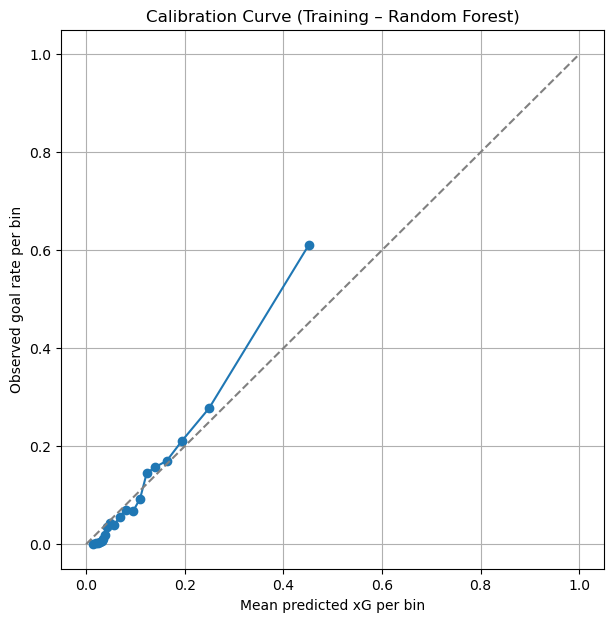

In [28]:
# ============================================================
# Random Forest – Calibration
# ============================================================

plot_calibration(
    df1,
    X_train.index,
    "xG_rf_train",
    n_bins=20,
    title="Calibration Curve (Training – Random Forest)"
)

RF vs StatsBomb (Test): 0.8322253263486368


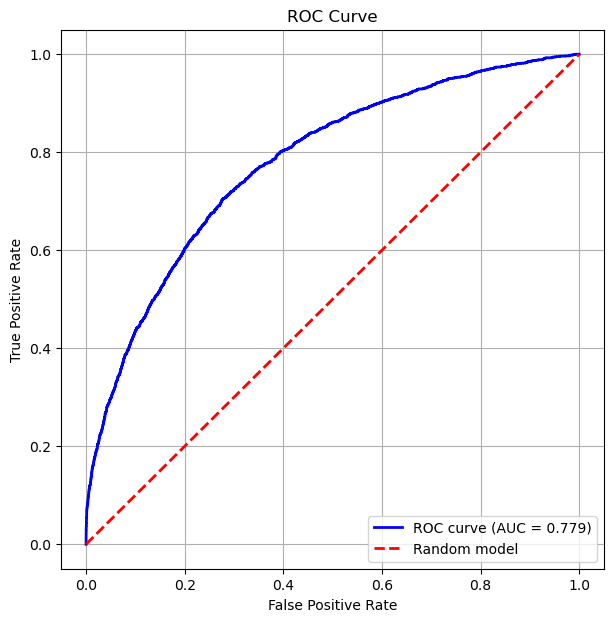

RF Test AUC: 0.7790027425032754
RF Test Log Loss: 0.2746741793825855
RF TRAIN – Real: 4806 Expected: 4790.2143553704445
RF TEST  – Real: 2060 Expected: 2063.424368014102


In [29]:

# ============================================================
# Random Forest – Comparison with StatsBomb xG
# ============================================================

corr_test_rf = correlation_with_statsbomb(df1, X_test.index, "xG_rf_test")
print("RF vs StatsBomb (Test):", corr_test_rf)

# ============================================================
# Random Forest – ROC & Log Loss (Test)
# ============================================================

y_score_test_rf = df1.loc[X_test.index, "xG_rf_test"].values

roc_auc_rf = plot_roc_curve(y_test.values, y_score_test_rf)
logloss_rf = compute_log_loss(y_test.values, y_score_test_rf)

print("RF Test AUC:", roc_auc_rf)  
print("RF Test Log Loss:", logloss_rf)

# ============================================================
# Random Forest – Real vs Expected Goals
# ============================================================

real_train_rf, expected_train_rf = real_vs_expected_goals(
    df1, X_train.index, "xG_rf_train"
)
real_test_rf, expected_test_rf = real_vs_expected_goals(
    df1, X_test.index, "xG_rf_test"
)

print("RF TRAIN – Real:", real_train_rf, "Expected:", expected_train_rf) 
print("RF TEST  – Real:", real_test_rf, "Expected:", expected_test_rf) 


In [30]:

# ============================================================
# XGBoost xG Model
# ============================================================

xgb_model = train_xgb_model(X_train, y_train)

df1 = xgb_predictions(
    df1,
    xgb_model,
    X_train,
    X_test,
    col_train="xG_xgb_train",
    col_test="xG_xgb_test"
)


In [31]:

# ============================================================
# XGBoost – Mean xG by Outcome
# ============================================================

mean_goal_train, mean_nongoal_train = mean_xg_by_outcome(
    df1, X_train.index, "xG_xgb_train"
)
mean_goal_test, mean_nongoal_test = mean_xg_by_outcome(
    df1, X_test.index, "xG_xgb_test"
)

print("XGB TRAIN – Mean xG GOAL:", mean_goal_train) 
print("XGB TRAIN – Mean xG NO GOAL:", mean_nongoal_train) 
print("XGB TEST  – Mean xG GOAL:", mean_goal_test)
print("XGB TEST  – Mean xG NO GOAL:", mean_nongoal_test) 


XGB TRAIN – Mean xG GOAL: 0.2490781
XGB TRAIN – Mean xG NO GOAL: 0.08455846
XGB TEST  – Mean xG GOAL: 0.23622712
XGB TEST  – Mean xG NO GOAL: 0.08695456


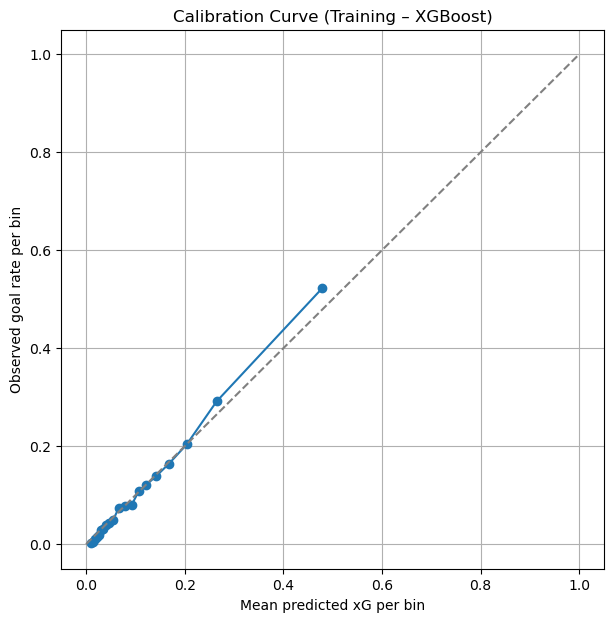

In [32]:

# ============================================================
# XGBoost – Calibration
# ============================================================

plot_calibration(
    df1,
    X_train.index,
    "xG_xgb_train",
    n_bins=20,
    title="Calibration Curve (Training – XGBoost)"
)


XGB vs StatsBomb (Test): 0.8286699092859471


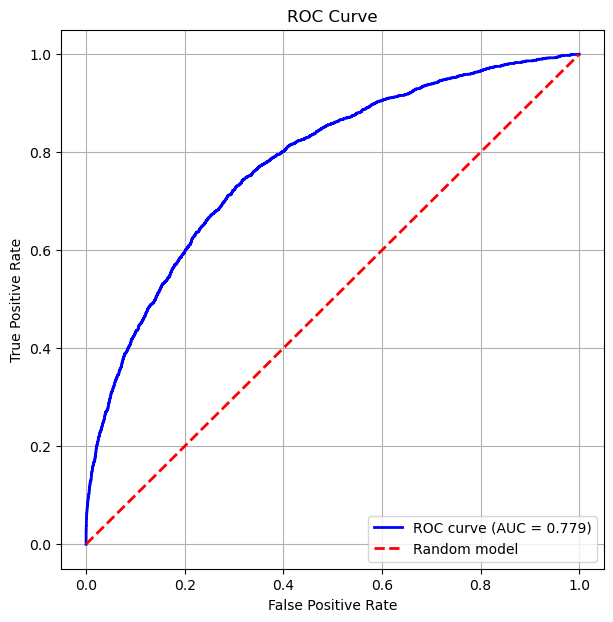

XGB Test AUC: 0.7794097481593564
XGB Test Log Loss: 0.27469748416072065
XGB TRAIN – Real: 4806 Expected: 4802.388
XGB TEST  – Real: 2060 Expected: 2075.6355


In [33]:

# ============================================================
# XGBoost – Comparison with StatsBomb xG
# ============================================================

corr_test_xgb = correlation_with_statsbomb(df1, X_test.index, "xG_xgb_test")
print("XGB vs StatsBomb (Test):", corr_test_xgb) 

# ============================================================
# XGBoost – ROC & Log Loss (Test)
# ============================================================

y_score_test_xgb = df1.loc[X_test.index, "xG_xgb_test"].values

roc_auc_xgb = plot_roc_curve(y_test.values, y_score_test_xgb)
logloss_xgb = compute_log_loss(y_test.values, y_score_test_xgb)

print("XGB Test AUC:", roc_auc_xgb) 
print("XGB Test Log Loss:", logloss_xgb) 

# ============================================================
# XGBoost – Real vs Expected Goals
# ============================================================

real_train_xgb, expected_train_xgb = real_vs_expected_goals(
    df1, X_train.index, "xG_xgb_train"
)
real_test_xgb, expected_test_xgb = real_vs_expected_goals(
    df1, X_test.index, "xG_xgb_test"
)

print("XGB TRAIN – Real:", real_train_xgb, "Expected:", expected_train_xgb)
print("XGB TEST  – Real:", real_test_xgb, "Expected:", expected_test_xgb) 


In [34]:
# ============================================================
# XGBoost – Feature Importance
# ============================================================

importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": xgb_model.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
)

print("Top XGBoost features:")
print(importance.head(15))


Top XGBoost features:
                           feature  importance
5                   shot_open_goal    0.319151
1                  shot_aerial_won    0.157604
10                   opening_angle    0.113249
3                  shot_one_on_one    0.071667
8                         distance    0.060580
13    macro_play_pattern_Set Piece    0.048790
2                  shot_first_time    0.040475
4                   under_pressure    0.028486
15  macro_position_Central Forward    0.018725
18           macro_position_Winger    0.018593
17       macro_position_Midfielder    0.018286
14     macro_play_pattern_Throw In    0.017571
9                            angle    0.016450
6                    shot_redirect    0.013557
12        macro_play_pattern_Other    0.013354


### Model Comparison and Selection

The final model choice is based on a joint evaluation of multiple performance criteria. In particular, models are compared in terms of ROC AUC, log-loss, and their ability to reproduce the total number of observed goals through the sum of predicted xG.

While the logistic regression provides a strong and interpretable baseline, tree-based models show superior performance. Among them, **XGBoost consistently achieves the highest AUC**, the **lowest log-loss**, and the **closest alignment between expected goals and observed goals**.

Taken together, these results indicate that XGBoost offers the best trade-off between discriminative power, probabilistic accuracy, and aggregate consistency. For this reason, it is selected as the final model for feature interpretation and further analysis.

### Top XGBoost Features

The feature importance analysis highlights which variables contribute most to the predictive performance of the XGBoost model. As expected, contextual and geometric shot characteristics dominate.

The most influential feature is **open goal**, confirming that shots taken without a goalkeeper in position dramatically increase scoring probability. **Aerial shots** emerge as a strong negative discriminator, reflecting their lower efficiency compared to shots taken on the ground.

Geometric variables such as **opening angle** and **distance**, play a central role, reinforcing the importance of shot location and visible goal area. Situational indicators like **one-on-one scenarios**, **first-time shots**, and **defensive pressure** further refine shot quality assessment.

Overall, the importance ranking is highly consistent with football domain knowledge and confirms that the model relies on meaningful and interpretable information.

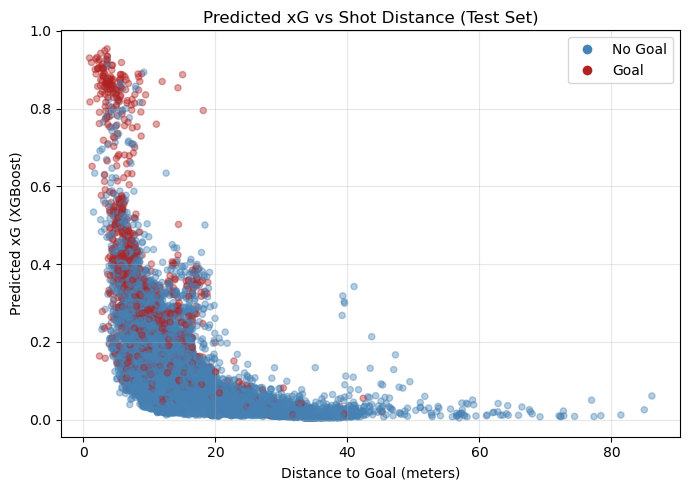

In [35]:

# ============================================================
# XGBoost – Learned xG Surface (Distance Diagnostic)
# ============================================================

plot_xg_vs_distance(
    df=df1,
    X_test_index=X_test.index,
    xg_col="xG_xgb_test",
    dist_col="distance",
    outcome_col="Outcome"
)

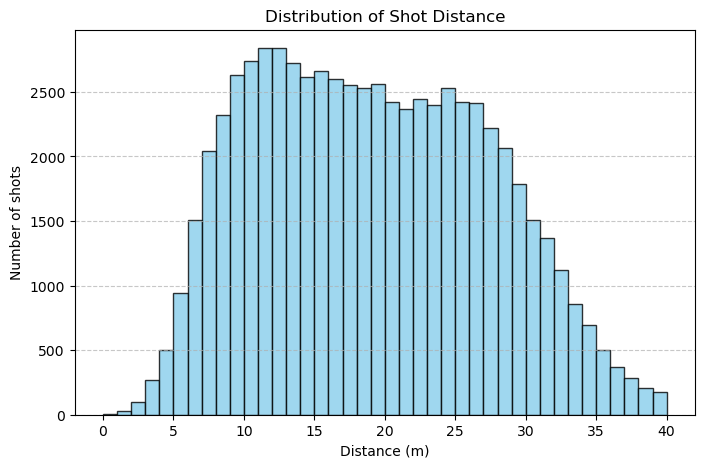

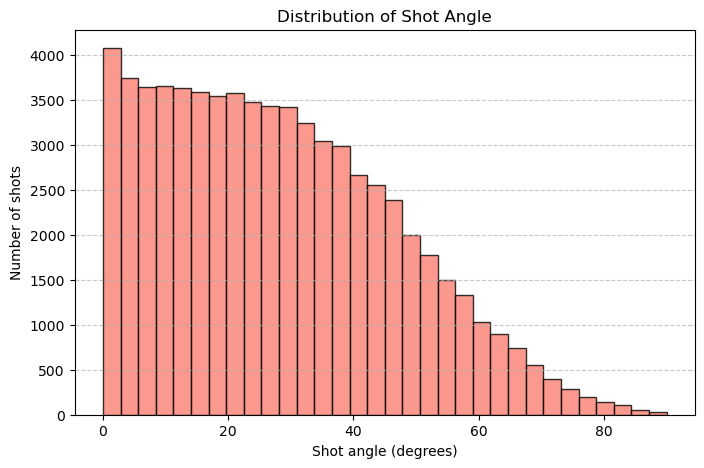

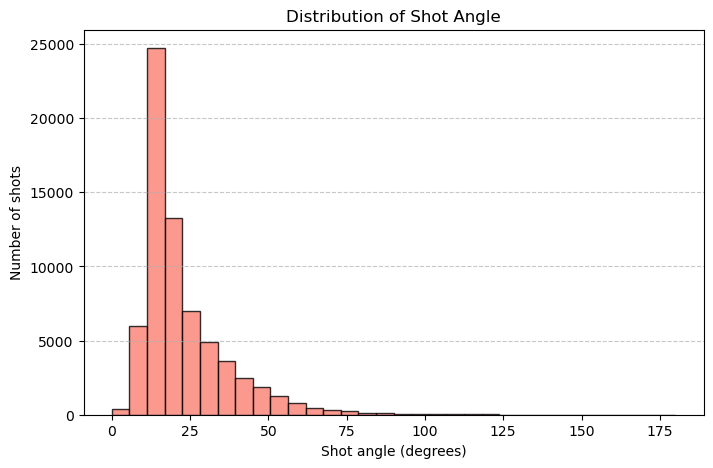

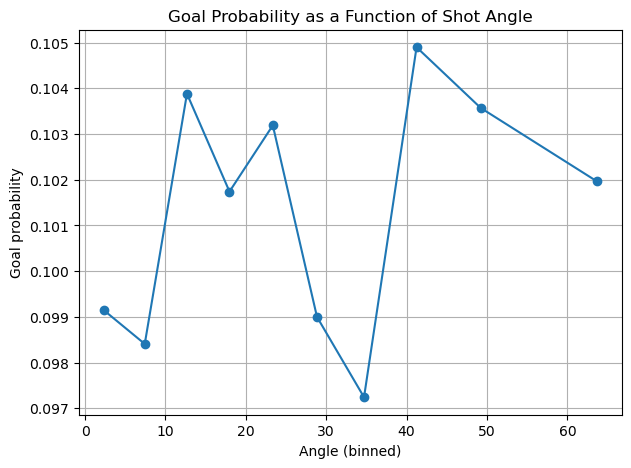

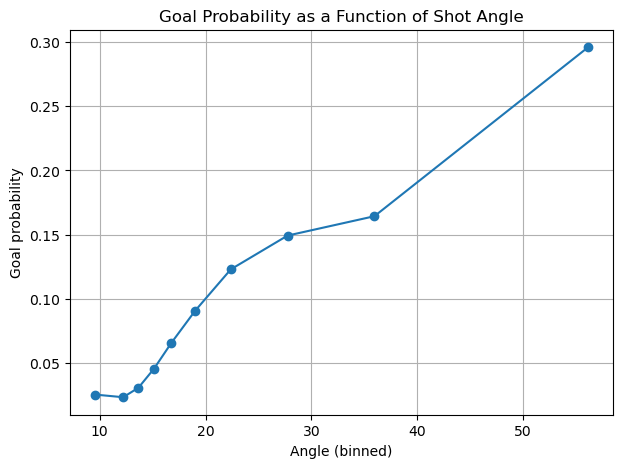

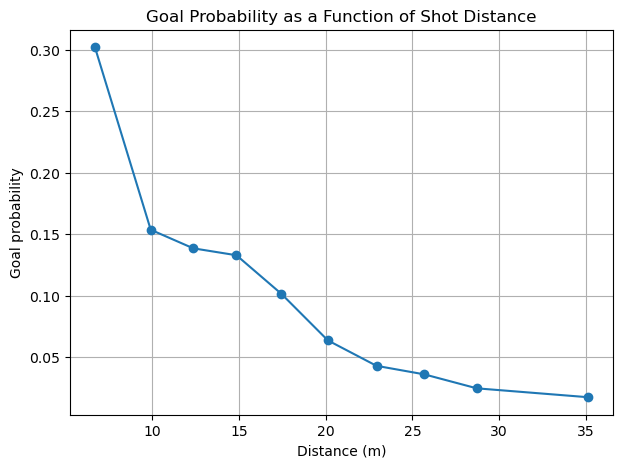

In [36]:

# ============================================================
# Exploratory Data Analysis (EDA) – Shot Geometry
# ============================================================
# Analysis of core geometric variables underlying xG:
# - shot distance
# - shot angle
# - binned goal probability relationships

# Distribution of shot distance
plot_shot_distance_distribution(X, "distance")

# Distribution of opening_angle

plot_shot_angle_distribution(X, "opening_angle")

# Goal probability vs angle (binned)
plot_goal_prob_by_angle(
    df1,
    angle_col="angle",
    outcome_col="Outcome",
    n_bins=10
)

plot_goal_prob_by_angle(
    df1,
    angle_col="opening_angle",
    outcome_col="Outcome",
    n_bins=10
)

# Goal probability vs distance (binned)
plot_goal_prob_by_distance(
    df1,
    dist_col="distance",
    outcome_col="Outcome",
    n_bins=10
)

In [40]:
# ============================================================
# EDA – Role-based Shot Characteristics
# ============================================================

roles = [
    "macro_position_Central Forward",
    "macro_position_Winger",
    "macro_position_Midfielder",
    "macro_position_Fullback"
]

# Average shot angle by role (baseline: Center Back) 
mean_shot_angle_by_role(
    df1,
    roles,
    angle_col="angle",
    baseline_role="Center Back"
)

{'macro_position_Central Forward': 29.582767000849014,
 'macro_position_Winger': 29.88883446551629,
 'macro_position_Midfielder': 24.444313455862126,
 'macro_position_Fullback': 32.34883567250681,
 'Center Back': 25.37917318997745}

### Mean Shot Angle by Player Role

The average shot angle varies across player roles. Fullbacks and wingers tend to shoot from wider positions, resulting in larger angles, while central forwards and midfielders take shots from more central locations. 

In [41]:

mean_shot_angle_by_role(
    df1,
    roles,
    angle_col="opening_angle",
    baseline_role="Center Back"
)

{'macro_position_Central Forward': 26.104041385491417,
 'macro_position_Winger': 20.926690844536136,
 'macro_position_Midfielder': 19.776974118148466,
 'macro_position_Fullback': 17.985792057776163,
 'Center Back': 34.86161442361613}

### Mean Opening Angle by Player Role

The average opening angle differs substantially across player roles. Center backs exhibit the largest opening angles, likely reflecting shots taken from central and close-range situations such as set pieces or rebounds. In contrast, fullbacks and wingers tend to have smaller opening angles, consistent with shots taken from wider and more constrained shooting positions.


In [43]:
# Average shot distance by role (baseline: Center Back)

mean_shot_distance_by_role(
    df1,
    roles,
    dist_col="distance",
    baseline_role="Center Back"
)

# Empirical scoring probability conditioned on player role

goal_rate_by_role_dict = goal_prob_by_role(
    df,
    roles,
    baseline_role="Center Back",
    outcome_col="Outcome"
)

print("Goal probability by role:")
print(goal_rate_by_role_dict)


Goal probability by role:
{'macro_position_Central Forward': 0.13801095659502738, 'macro_position_Winger': 0.11034519898755991, 'macro_position_Midfielder': 0.07008930903013527, 'macro_position_Fullback': 0.0637759406107643, 'Center Back': 0.09262135922330098}


### Shot Distance and Empirical Goal Probability by Player Role

Average shooting distance varies markedly across player roles and aligns well with observed scoring probabilities. Central forwards take shots from the shortest average distance and exhibit the highest goal rate, reflecting their proximity to goal and more favorable shooting contexts.

Wingers, midfielders, and fullbacks tend to shoot from progressively longer distances, which is mirrored by a steady decline in empirical scoring probability. Despite center backs taking shots from relatively short distances, their goal rate is lower than that of central forwards, likely due to more contested and less controlled shooting situations.


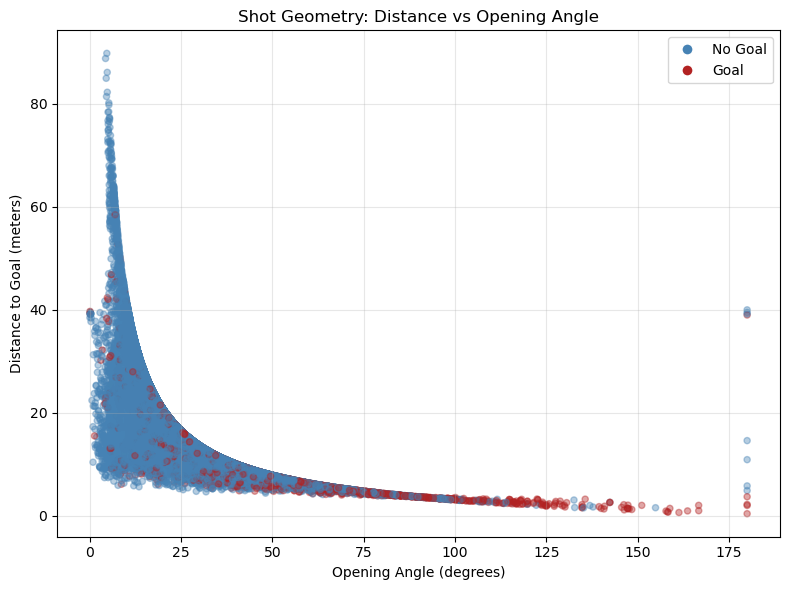

In [44]:

# ============================================================
# EDA – Shot Geometry and Goal Distribution
# ============================================================
# Shot-level relationship between opening angle and distance.
# Points are colored by observed outcome (Goal / No Goal).

plot_distance_vs_opening_angle(
    df=df1,
    x_col="opening_angle",
    y_col="distance",
    outcome_col="Outcome"
)


In [45]:

# ============================================================
# EDA – Defensive Pressure Effect by Distance
# ============================================================
# Analysis of how defensive pressure modifies scoring probability
# across distance bins

pressure_effect = goal_prob_by_distance_pressure(
    df,
    n_bins=10
)

print("Goal probability under pressure by distance bin:")
print(pressure_effect)

Goal probability under pressure by distance bin:
under_pressure           0         1
dist_bin                            
(0.399, 8.59]     0.377308  0.185575
(8.59, 11.165]    0.194867  0.093829
(11.165, 13.591]  0.161448  0.092952
(13.591, 16.125]  0.139143  0.116192
(16.125, 18.783]  0.105068  0.090024
(18.783, 21.534]  0.063208  0.065041
(21.534, 24.319]  0.043660  0.039844
(24.319, 27.098]  0.038306  0.023919
(27.098, 30.591]  0.025142  0.021627
(30.591, 89.829]  0.018715  0.006766


Goal probability for binary variables:
{'shot_aerial_won': shot_aerial_won
0    0.103952
1    0.072922
Name: Outcome, dtype: float64, 'shot_first_time': shot_first_time
0    0.083305
1    0.140842
Name: Outcome, dtype: float64, 'shot_one_on_one': shot_one_on_one
0    0.093171
1    0.245174
Name: Outcome, dtype: float64, 'under_pressure': under_pressure
0    0.104630
1    0.091175
Name: Outcome, dtype: float64, 'shot_open_goal': shot_open_goal
0    0.094099
1    0.753036
Name: Outcome, dtype: float64, 'shot_redirect': shot_redirect
0    0.100711
1    0.371622
Name: Outcome, dtype: float64, 'shot_follows_dribble': shot_follows_dribble
0    0.101283
1    0.130435
Name: Outcome, dtype: float64}


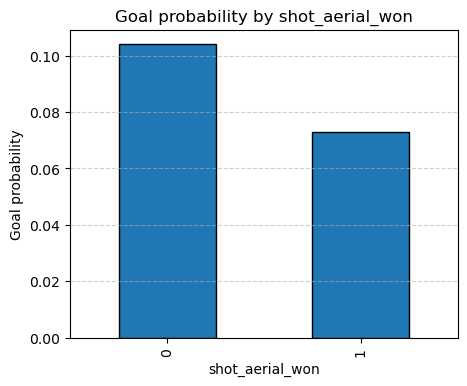

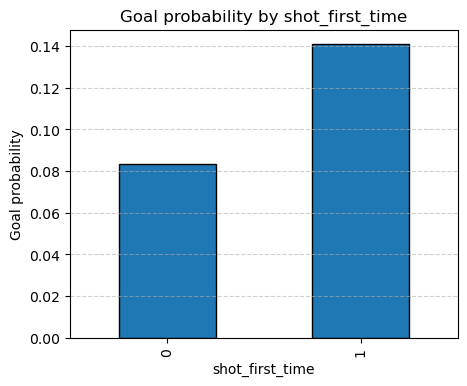

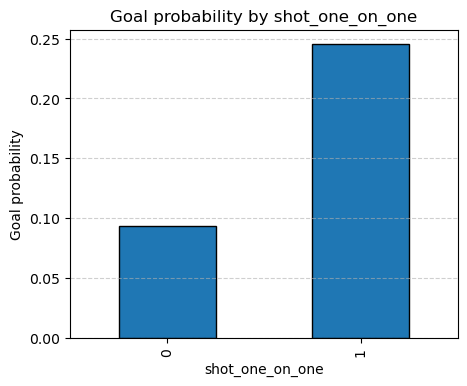

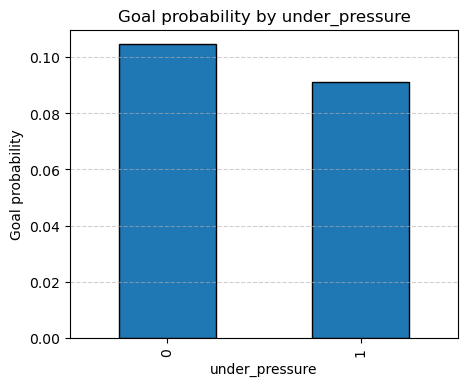

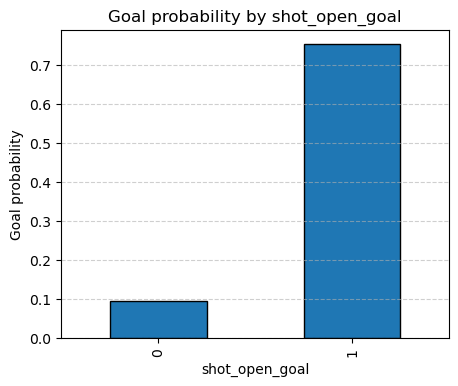

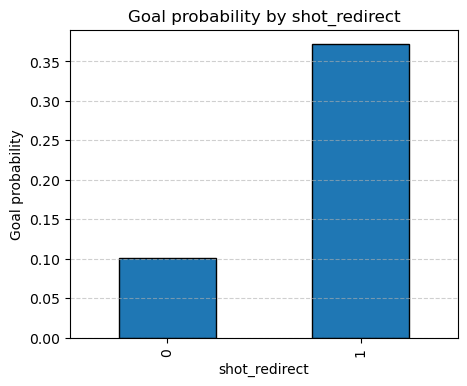

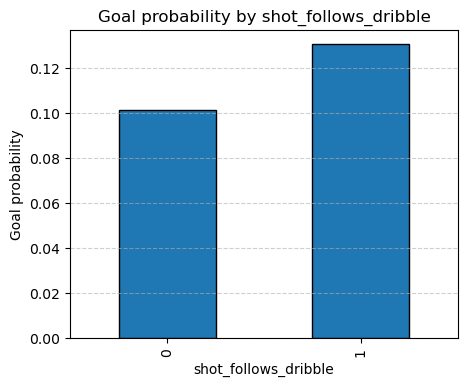

In [46]:

# ============================================================
# EDA – Binary Contextual Variables
# ============================================================
# Goal probability conditioned on binary shot context variables

binary_vars = [
    "shot_aerial_won",
    "shot_first_time",
    "shot_one_on_one",
    "under_pressure",
    "shot_open_goal",
    "shot_redirect",
    "shot_follows_dribble"
]

goal_rate_binary = goal_prob_by_binary_vars(
    df,
    binary_vars,
    outcome_col="Outcome"
)

plot_goal_prob_binary_vars(df, binary_vars)


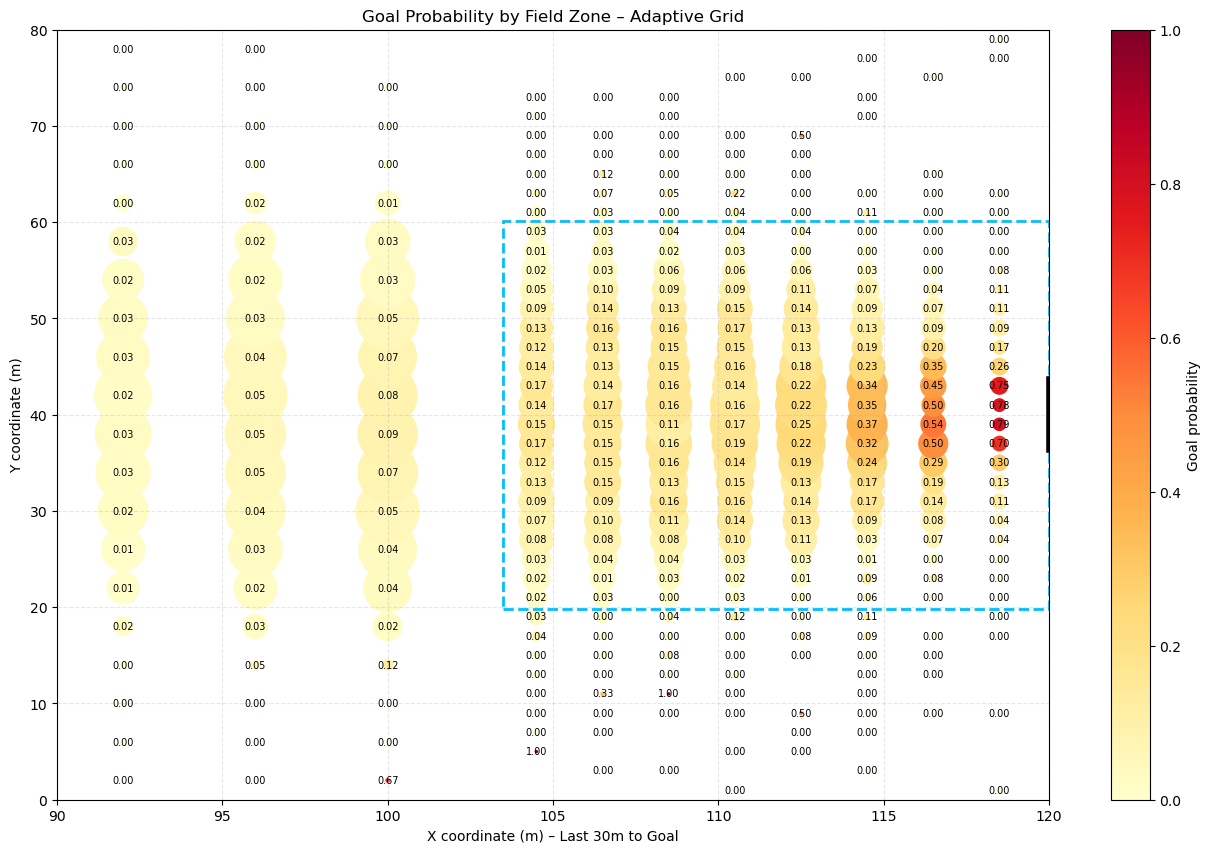

,rank,zone_type,x_bin,y_bin,shots,goals,goal_prob
0,1,Central,"(115.5, 117.5]","(38.0, 40.0]",157,85,0.541401
1,2,Central,"(115.5, 117.5]","(36.0, 38.0]",215,107,0.497674
2,3,Central,"(115.5, 117.5]","(40.0, 42.0]",129,64,0.496124
3,4,Central,"(115.5, 117.5]","(42.0, 44.0]",162,73,0.450617
4,5,Central,"(113.5, 115.5]","(38.0, 40.0]",411,151,0.367397
...,...,...,...,...,...,...,...
143,144,Wide,"(89.999, 94.0]","(24.0, 28.0]",471,7,0.014862
144,145,Wide,"(98.0, 102.0]","(60.0, 64.0]",150,2,0.013333
145,146,Central,"(103.499, 105.5]","(56.0, 58.0]",160,2,0.012500
146,147,Wide,"(89.999, 94.0]","(20.0, 24.0]",256,3,0.011719


In [47]:

# ============================================================
# EDA – Pitch-level Spatial Analysis (Last 30m)
# ============================================================

# Adaptive grid (penalty area vs outside box)
pitch_stats = plot_adaptive_goal_grid(
    df,
    x_thresh_box=103.5,
    outcome_col="Outcome"
)

# Most dangerous zones by volume and conversion
top_zones_table(
    pitch_stats,
    min_shots=100
)


### Goal Probability by Field Zone

The pitch is divided using an adaptive grid, with a specific focus on the last 30 meters. The dashed area highlights shots taken **inside the penalty box**, while zones outside this region correspond to shots from **outside the box**. For each zone, the empirical goal probability is computed based on observed shot outcomes, with circle size reflecting shot volume.

Clear spatial patterns emerge. Goal probability increases sharply in central areas close to the goal, particularly around the penalty spot and within the central corridor of the box. Wide areas and zones outside the box exhibit substantially lower conversion rates, despite often featuring higher shot volumes. This highlights the strong interaction between shot location, angle, and distance, and reinforces the importance of spatial modeling in expected goals analysis.

=== SHOTS ON TARGET CHECK ===
Total shots on target (last 30m): 21997


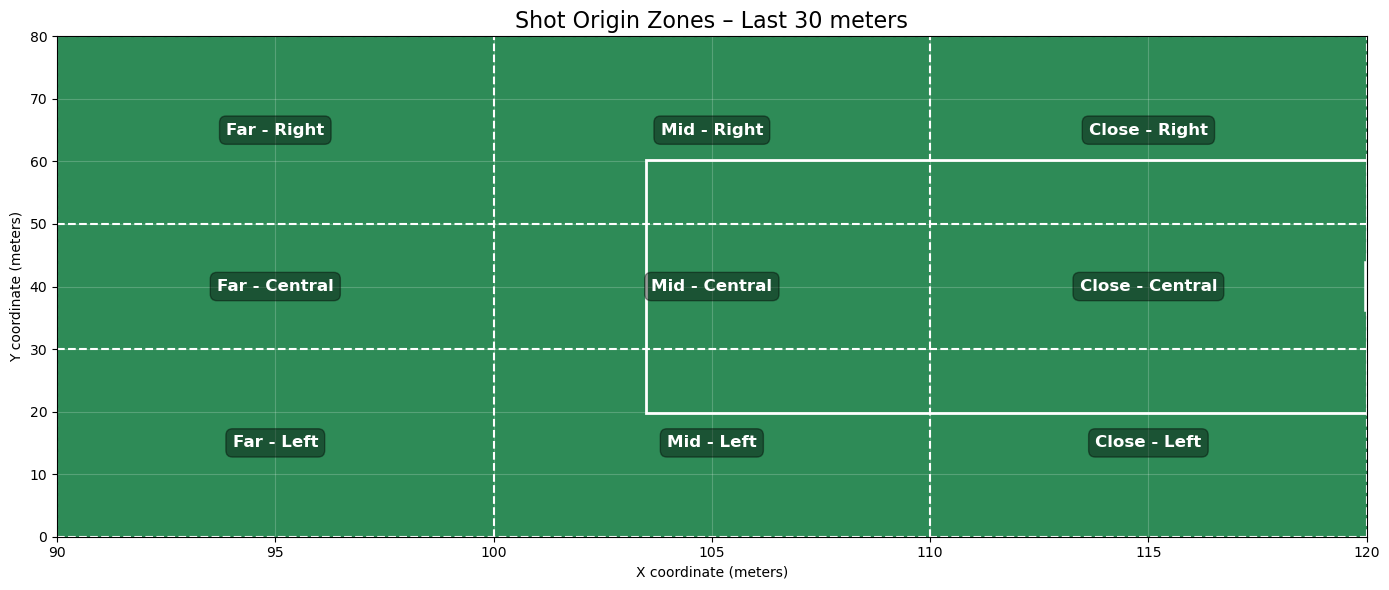

Zone Close - Central → 5834 shots


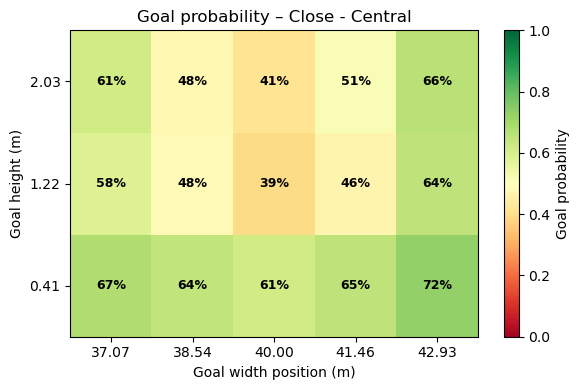

Zone Close - Left → 1010 shots


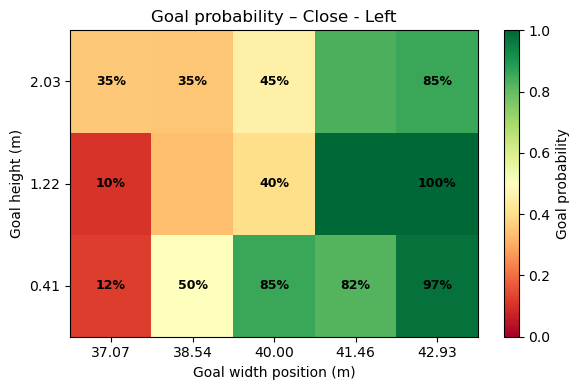

Zone Close - Right → 949 shots


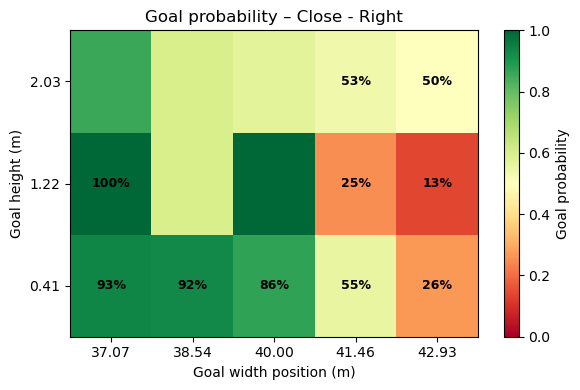

Zone Far - Central → 2780 shots


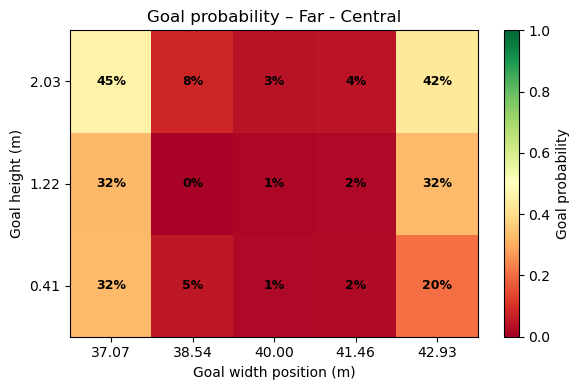

Zone Far - Left → 1116 shots


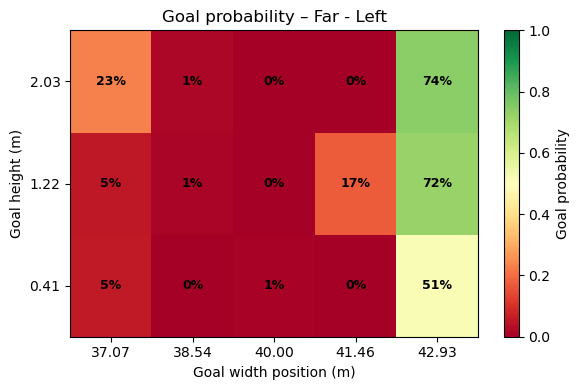

Zone Far - Right → 945 shots


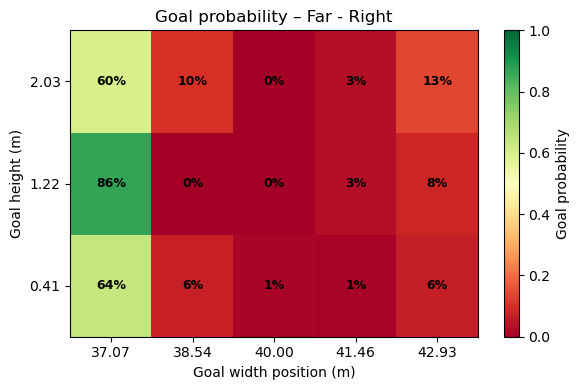

Zone Mid - Central → 5762 shots


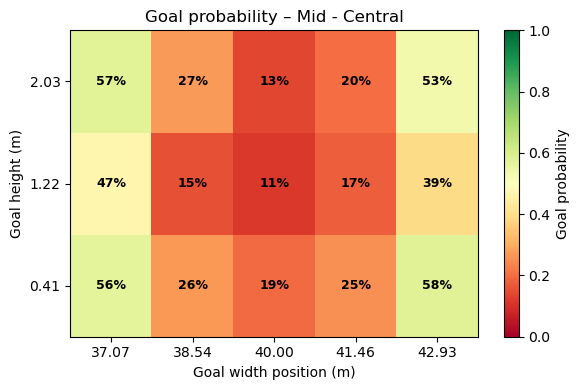

Zone Mid - Left → 1911 shots


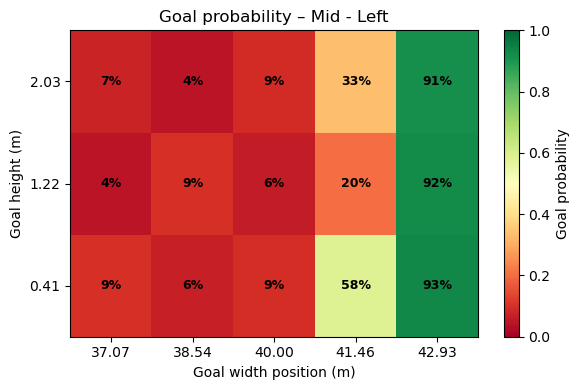

Zone Mid - Right → 1690 shots


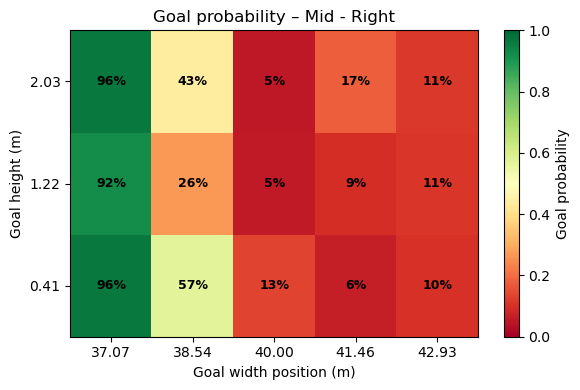

In [48]:

# ============================================================
# EDA – Shots on Target & Goal Frame Analysis
# ============================================================
# Spatial distribution of shots on target and goal-mouth targeting

# Select shots on target in the final 30 meters
df_on = select_shots_on_target(df, min_x=90)

print("=== SHOTS ON TARGET CHECK ===")
print(f"Total shots on target (last 30m): {len(df_on)}")

# Assign shot zones
df_on = assign_shot_zones(df_on)

# Visualize shot zones on pitch
plot_shot_zones_field(df_on)

# ------------------------------------------------------------
# Goal frame discretization (5 × 3 = 15 bins)
# ------------------------------------------------------------

GOAL_Y_MIN = 40 - 7.32 / 2
GOAL_Y_MAX = 40 + 7.32 / 2

y_bins_goal = np.linspace(GOAL_Y_MIN, GOAL_Y_MAX, 6)
z_bins_goal = np.linspace(0, 2.44, 4)

# Goal-mouth heatmaps by shot zone
plot_goal_heatmaps_by_shot_zone(
    df_on,
    y_bins_goal=y_bins_goal,
    z_bins_goal=z_bins_goal,
    min_shots=10
)


### Shots on Target Analysis

The first figure divides the last 30 meters of the pitch into **nine shot origin zones**, combining three horizontal distances (*Far, Mid, Close*) with three lateral positions (*Left, Central, Right*). This spatial discretization allows shots on target to be grouped according to their origin, providing a structured framework for analyzing finishing behavior from different areas of the pitch. Only **shots on target** are considered, resulting in a total of 21,997 observations.

The main objective of this analysis is to study **how the probability of scoring varies depending on where the ball is placed within the goal**, conditional on the shot origin zone. To this end, the goal is discretized into a **5 × 3 grid (15 bins)**, and empirical scoring probabilities are computed for each cell. This is a descriptive and exploratory analysis: no information about shot speed, body part, defensive pressure, or goalkeeper positioning is considered.

Clear and intuitive spatial patterns emerge across the nine shot origin zones. For **close central shots**, scoring probabilities are lowest in the central area of the goal (around 20%) and increase substantially toward both sides, often exceeding 50%. This is consistent with goalkeepers positioning themselves centrally, making centrally placed shots easier to save.

For **close left** shots, goal probability is highest on the **right side of the goal**, with values often exceeding 90%, while probabilities drop sharply toward the left side, in some cases below 15%. The opposite pattern is observed for **close right** shots, where the highest conversion rates are concentrated on the **left side of the goal**. These mirrored patterns suggest that goalkeepers tend to protect the near post, leaving the far side more exposed.

Moving to **mid-range shots**, the same directional structure persists but with generally lower conversion rates. Central shots from mid distance show relatively low probabilities in the center of the goal (around 20%), while probabilities increase toward the lateral sections. For **mid-left** shots, scoring probability peaks on the right side of the goal (up to 90%) and decreases steeply toward the left, while **mid-right** shots exhibit the reverse pattern.

For **far central shots**, overall scoring probabilities are substantially lower, with central goal areas often below 5%. However, probabilities increase toward the left and right sides of the goal, reaching values around 30%. When shooting from **far left** or **far right** zones, conversion rates are generally very low across the goal mouth, except for the far-post side, where probabilities increase relative to other target areas.

Across all shot origin zones, a consistent global pattern emerges: **scoring probabilities decrease as shooting distance increases**, probabilities are **lowest when shots are directed centrally**, and **highest when shots are placed toward the corners of the goal**. In particular, shots aimed at the upper corners or low angles near the posts consistently show the highest conversion rates, confirming these areas as the most difficult for goalkeepers to defend.